In [ ]:
#importing the Libraries
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#preparation of samples for training and validation
#so the dataset is imported from the git of another person who owns this dataset.(Maurizio Pierinim)

In [ ]:
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset/

Cloning into 'tutorials'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 690 (delta 51), reused 92 (delta 32), pack-reused 579
Receiving objects: 100% (690/690), 565.84 MiB | 28.14 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Checking out files: 100% (75/75), done.
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


Since we will be using convolutional Neural Network, we will us jet Images for training the model.


In [ ]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, jetImage.shape)

Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImage, target

(33500, 100, 100) (16500, 100, 100) (33500, 5) (16500, 5)


CONV 2d MODEL BUILDING

In [ ]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [ ]:
image_shape = (img_rows, img_cols, 1)
####
inputImage = Input(shape=(image_shape))
x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x)
x = Dropout(dropoutRate)(x)
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputImage, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 5)       130       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 5)      20        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 5)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 5)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 5)         0     

In [ ]:
batch_size = 128
n_epochs = 200
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 263s - loss: 1.6481 - val_loss: 1.5344 - lr: 0.0010 - 263s/epoch - 1s/step
Epoch 2/200
262/262 - 190s - loss: 1.5373 - val_loss: 1.4749 - lr: 0.0010 - 190s/epoch - 725ms/step
Epoch 3/200
262/262 - 185s - loss: 1.4833 - val_loss: 1.4296 - lr: 0.0010 - 185s/epoch - 705ms/step
Epoch 4/200
262/262 - 187s - loss: 1.4312 - val_loss: 1.3943 - lr: 0.0010 - 187s/epoch - 714ms/step
Epoch 5/200
262/262 - 263s - loss: 1.3919 - val_loss: 1.3463 - lr: 0.0010 - 263s/epoch - 1s/step
Epoch 6/200
262/262 - 182s - loss: 1.3640 - val_loss: 1.3162 - lr: 0.0010 - 182s/epoch - 696ms/step
Epoch 7/200
262/262 - 185s - loss: 1.3422 - val_loss: 1.2894 - lr: 0.0010 - 185s/epoch - 705ms/step
Epoch 8/200
262/262 - 182s - loss: 1.3227 - val_loss: 1.2708 - lr: 0.0010 - 182s/epoch - 696ms/step
Epoch 9/200
262/262 - 189s - loss: 1.3059 - val_loss: 1.2608 - lr: 0.0010 - 189s/epoch - 723ms/step
Epoch 10/200
262/262 - 183s - loss: 1.2965 - val_loss: 1.2418 - lr: 0.0010 - 183s/epoch - 700ms/step
Epoch

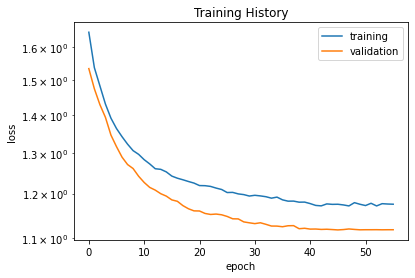

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Building The ROC curves

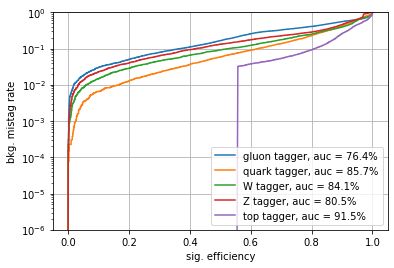

In [ ]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()